In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import time
import sys
import resource
from torch.utils.data import DataLoader

from data_classes import *
from read_input import *
from read_trainset import *
from network import *
from prepare_batches import *
from traininit import *
from data_set import *
from data_loader import *
from optimization_step import *
from output_nn import *
from py_aeio import *

/nethome/farri002/miniconda3/envs/tyxe/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cpu"

In [4]:
tin_file = "/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/NN-20-20/train.in"
tin = read_train_in(tin_file)
torch.manual_seed(tin.pytorch_seed)
np.random.seed(tin.numpy_seed)
if tin.verbose: io_input_reading(tin)
tin.train_file = '/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/data.train.ascii'
tin.train_forces_file = '/nethome/farri002/mlp-pt-au-o-h/ml-construction/PdO/desc-20-8/data.train.forces'

In [5]:
if tin.verbose : io_trainingset_information()
list_structures_energy, list_structures_forces, list_removed, max_nnb, tin = read_list_structures(tin)

In [6]:
N_removed = len(list_removed)
N_struc_E = len(list_structures_energy)
N_struc_F = len(list_structures_forces)
if tin.verbose : io_trainingset_information_done(tin, tin.trainset_params, N_struc_E, N_struc_F, N_removed)

if tin.verbose : io_prepare_batches()

N_batch_train, N_batch_valid = select_batch_size(tin, list_structures_energy, list_structures_forces)

# Join datasets with forces and only energies in a single torch dataset AND prepare batches
train_forces_data, valid_forces_data, train_energy_data, valid_energy_data = select_batches(tin, tin.trainset_params, device, list_structures_energy, list_structures_forces,
                                                                                        max_nnb, N_batch_train, N_batch_valid)

del list_structures_energy
del list_structures_forces

if tin.verbose : io_prepare_batches_done(tin, train_energy_data, train_forces_data)

In [7]:
grouped_train_data = GroupedDataset(train_energy_data, train_forces_data,
									 memory_mode=tin.memory_mode, device=device, dataname="train")
grouped_valid_data = GroupedDataset(valid_energy_data, valid_forces_data,
									 memory_mode=tin.memory_mode, device=device, dataname="valid")

In [10]:
del train_forces_data
del valid_forces_data
del train_energy_data
del valid_energy_data

In [11]:
# 4. Initialize dataloader
grouped_train_loader = DataLoader(grouped_train_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)
grouped_valid_loader = DataLoader(grouped_valid_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)

In [14]:
from bayesian_network import BayesianNetAtoms
from pyro.nn.module import to_pyro_module_
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro

model = NetAtom(tin.networks_param["input_size"], tin.networks_param["hidden_size"],
			    tin.sys_species, tin.networks_param["activations"], tin.alpha, device)

to_pyro_module_(model)

weight_labels = [f'Pt_h{i}_weight' for i in range(3)] + [f'O_h{i}_weight' for i in range(3)]
bias_labels = [f'Pt_h{i}_bias' for i in range(3)] + [f'O_h{i}_bias' for i in range(3)]

i = 0
for m in model.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        if name == 'weight':
            setattr(m, name, PyroSample(prior=dist.Normal(0, 1)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
        if name == 'bias':
            setattr(m, name, PyroSample(prior=dist.Normal(0, 10)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
            i += 1

def bayesian_net(grp_descrp, logic_reduce, grp_energy=None):
    
    local_plates = {i : pyro.plate(f'iest_{i}', len(grp_descrp[i])) for i in range(len(model.species))}
    local_sigma = {iesp : pyro.sample(f'noise_{iesp}', dist.Uniform(0,10)) for iesp in range(len(model.species))}
    sigma_fin = pyro.sample('noise', dist.Uniform(0,10))

    partial_E_ann = [0 for i in range(len(model.species))]

    for iesp, local_plate in local_plates.items():
        partial_E_ann[iesp] = model.functions[iesp](grp_descrp[iesp])

    list_E_ann = torch.zeros( (len(logic_reduce[0])), device=model.device ).double()
    for iesp in range(len(model.species)):
        list_E_ann = list_E_ann + torch.einsum( "ij,ki->k", partial_E_ann[iesp], logic_reduce[iesp])

    with pyro.plate('data', size = len(logic_reduce[0])):#, subsample_size= 128) as ind: # number of configurations
        a = pyro.sample('obs', dist.Normal(list_E_ann, sigma_fin), obs=grp_energy)
         #obs=grp_energy.index_select(0, ind))
        
    return list_E_ann
      
def bnn(grp_descrp, logic_reduce, grp_energy=None):    
    partial_E_ann = [0 for i in range(len(model.species))]
        
    for iesp in range(len(model.species)):
        partial_E_ann[iesp] = model.functions[iesp](grp_descrp[iesp])

    # Gather back all atoms corresponding to the same strucuture from partial_E_ann
    
    sigma = pyro.sample('noise', dist.Uniform(0,10))
    with pyro.plate('data', len(logic_reduce[0])):

        list_E_ann = torch.zeros( (len(logic_reduce[0])), device=model.device ).double()
        for iesp in range(len(model.species)):
            list_E_ann = list_E_ann + torch.einsum( "ij,ki->k", partial_E_ann[iesp], logic_reduce[iesp] )
        pyro.sample('obs', dist.Normal(list_E_ann, sigma), obs=grp_energy)
    return list_E_ann

# model = BayesianNetAtoms(net)       
guide = AutoDiagonalNormal(bayesian_net)

In [34]:
def get_train_test(grouped_train_loader):
    for data_batch in grouped_train_loader:
        grp_descrp, grp_energy, logic_reduce = data_batch[0][10], data_batch[0][11], data_batch[0][12]

    grp_descrp[0] = grp_descrp[0].float()
    grp_descrp[1] = grp_descrp[1].float()

    logic_reduce[0] = logic_reduce[0].float()
    logic_reduce[1] = logic_reduce[1].float()

    return grp_descrp, grp_energy, logic_reduce

In [55]:
from pyro.infer import SVI, Trace_ELBO

grp_descrp, grp_energy, logic_reduce = get_train_test(grouped_train_loader)
pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.05})
svi = SVI(bayesian_net, guide, adam, loss=Trace_ELBO())
elbos = []
for x in range(20000):
    elbos.append(svi.step(grp_descrp, logic_reduce, grp_energy))

In [ ]:
grp_descrp, grp_energy, logic_reduce = get_train_test(grouped_valid_loader)

In [45]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).numpy(),
            "std": torch.std(v, 0).numpy(),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0].numpy(),
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0].numpy(),
        }
    return site_stats


predictive = Predictive(bnn, guide=guide, num_samples=800,
                        return_sites=("weight", "obs", "_RETURN"))

samples = predictive(grp_descrp, logic_reduce)
pred_summary = summary(samples)
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]

(-38.0, -31.5)

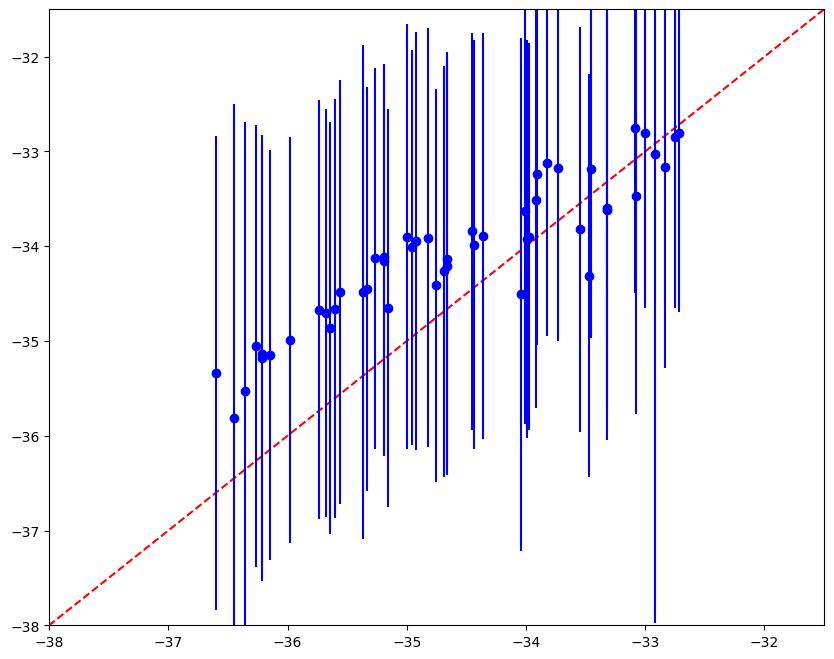

In [46]:
import numpy as np
import matplotlib.pyplot as plt
i = 0
fig, ax = plt.subplots(1,1, figsize=(10,8))
x = np.linspace(-100,100,1000)
ax.plot(x,x, '--r')
for y_pred, y_std, y in zip(mu['mean'], mu['std'], grp_energy):
    #plt.scatter(y, y_pred, color='b')
    ax.errorbar(y, y_pred,fmt='o', c='blue', yerr=y_std)
    #ax[1].errorbar(y_pred, y,fmt='o', c='red', xerr=y_std)
    i += 1

    if i == 50:
        break

ax.set_ylim(-38,-31.5)
ax.set_xlim(-38,-31.5)


In [47]:
grp_descrp, grp_energy, logic_reduce = get_train_test(grouped_valid_loader)
for x in range(10000):
    elbos.append(svi.step(grp_descrp, logic_reduce, grp_energy))

In [51]:
samples = predictive(grp_descrp, logic_reduce)
pred_summary = summary(samples)
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]

(-38.0, -31.5)

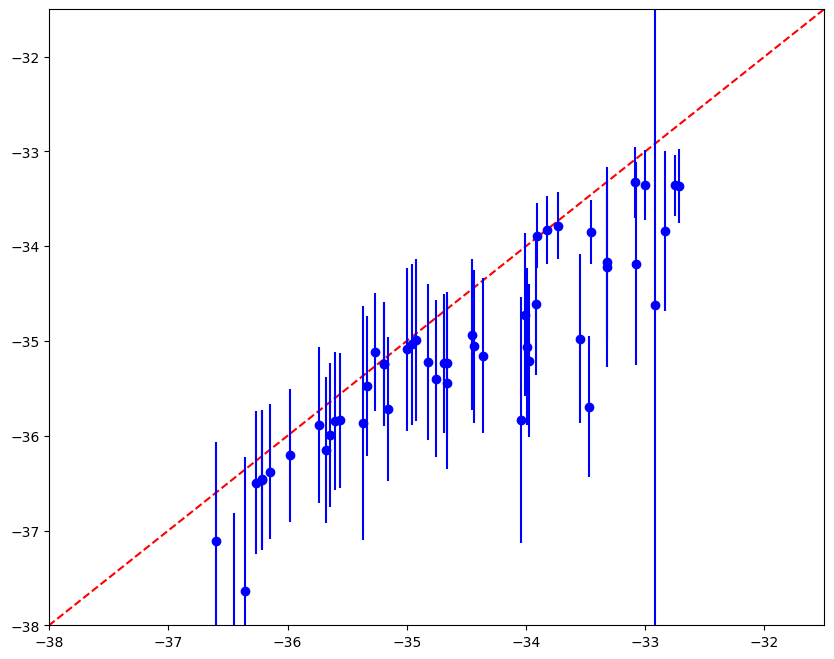

In [53]:
i = 0
fig, ax = plt.subplots(1,1, figsize=(10,8))
x = np.linspace(-100,100,1000)
ax.plot(x,x, '--r')
for y_pred, y_std, y in zip(mu['mean'], mu['std'], grp_energy):
    #plt.scatter(y, y_pred, color='b')
    ax.errorbar(y, y_pred,fmt='o', c='blue', yerr=y_std)
    #ax[1].errorbar(y_pred, y,fmt='o', c='red', xerr=y_std)
    i += 1

    if i == 50:
        break

ax.set_ylim(-38,-31.5)
ax.set_xlim(-38,-31.5)

In [29]:
for i in zip(mu['_RETURN']['mean'], mu['_RETURN']['std'], grp_energy):
    print(i)

(-32.17991134122014, 0.9080880242909194, tensor(-35.2630, dtype=torch.float64))
(-31.29842812769115, 1.485673051534721, tensor(-33.0803, dtype=torch.float64))
(-31.095640621185304, 0.8518847069499551, tensor(-32.9987, dtype=torch.float64))
(-31.062216258049013, 0.7589689505429384, tensor(-32.7180, dtype=torch.float64))
(-30.883537215981633, 1.4282776824737098, tensor(-32.8367, dtype=torch.float64))
(-32.74475765556097, 1.1331190348227982, tensor(-34.4349, dtype=torch.float64))
(-32.706314021199944, 1.1345337872560601, tensor(-34.9522, dtype=torch.float64))
(-32.69975954176858, 1.1484318981263002, tensor(-34.4518, dtype=torch.float64))
(-32.40832112625241, 1.1883306539145915, tensor(-34.0074, dtype=torch.float64))
(-32.74712166847661, 1.0607945956014524, tensor(-34.6884, dtype=torch.float64))
(-32.74387921022251, 1.0921743300244635, tensor(-35.7366, dtype=torch.float64))
(-32.8728396467492, 1.1343946655029045, tensor(-36.2166, dtype=torch.float64))
(-32.75923109678551, 1.616921330757568

In [ ]:
model = BayesianNetAtoms(net.functions, net.species, net.device)

pyro.render_model(model, model_args=([torch.ones(108, 52),torch.ones(108, 52)], [torch.ones([4, 108]),torch.ones([4, 108])], torch.ones(4,)))#,grp_energy))

NameError: name 'net' is not defined

In [ ]:
# 4. Initialize dataloader
grouped_train_loader = DataLoader(grouped_train_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)
grouped_valid_loader = DataLoader(grouped_valid_data, batch_size=1, shuffle=False,
                                  collate_fn=custom_collate, num_workers=0)

In [ ]:
for data_batch in grouped_train_loader:
    grp_descrp, grp_energy, logic_reduce = data_batch[0][10], data_batch[0][11], data_batch[0][12]

In [ ]:
grp_energy

tensor([-27.0000, -17.8317,   2.4570,   3.1589], dtype=torch.float64)

In [ ]:
logic_reduce[0].shape

torch.Size([4, 108])

In [ ]:
grp_descrp[0] = grp_descrp[0].float()
logic_reduce[0] =logic_reduce[0].float()

In [ ]:
model.forward(grp_descrp, logic_reduce, grp_energy)

tensor([ 302.2620, -196.0373,  209.5111,  309.6779], grad_fn=<AddBackward0>)

In [ ]:
model.svi.step(grp_descrp, logic_reduce,grp_energy)

NotImplementedError: 
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
for m in model.modules():
    m.model(data_batch[0][10][0], data_batch[0][10][0], data_batch[0][12][0])

NotImplementedError: 

In [ ]:
model.model(data_batch[0][10], data_batch[0][12])

RuntimeError: expected scalar type Float but found Double

In [ ]:
for data_batch in grouped_train_loader:
    grp_descrp, grp_energy, logic_reduce, grp_N_atom = data_batch[0][10], data_batch[0][11], data_batch[0][12], data_batch[0][14]


In [ ]:
grp_N_atom

tensor([27., 27., 27., 27.], dtype=torch.float64)

In [ ]:
grp_descrp[0].shape

torch.Size([108, 52])

In [ ]:
for data_batch in grouped_train_loader:
    model.step(data_batch[0][10], data_batch[0][12])

RuntimeError: expected scalar type Float but found Double
                              Trace Shapes:        
                               Param Sites:        
                              Sample Sites:        
model.functions.0.Linear_Sp1_F1.weight dist | 15 52
                                      value | 15 52
  model.functions.0.Linear_Sp1_F1.bias dist | 15   
                                      value | 15   
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
data_batch[0][10]

[tensor([[-0.0789,  0.7212, -1.5706,  ...,  1.3901,  1.2308,  0.2393],
         [-1.0732,  0.9951,  0.0450,  ...,  0.4152, -0.1812,  0.9815],
         [ 0.3986, -0.4489,  0.1622,  ..., -0.2772, -0.7212,  0.4384],
         ...,
         [-0.6189, -2.1412,  1.5223,  ..., -1.7583, -1.2087, -2.4926],
         [ 1.6111,  0.4451, -0.4222,  ...,  0.3068,  0.3127, -0.5332],
         [-0.1283, -0.6618, -0.9102,  ...,  0.5214, -0.0743,  0.6787]],
        dtype=torch.float64),
 tensor([], size=(0, 52), dtype=torch.float64)]